## Part 1 -- Adjusting Time Series

### 1 -- Importing data

In [1]:
from fredapi import Fred
import pandas as pd
from scipy.stats import spearmanr
import numpy as np
import matplotlib.pyplot as plt
# API key from FRED: https://fred.stlouisfed.org/docs/api/api_key.html -- 5a72198ba82bfb30d23caa460eb6d4c3
fred = Fred(api_key='5a72198ba82bfb30d23caa460eb6d4c3')
# certificate error fix: 
# https://stackoverflow.com/questions/68275857/urllib-error-urlerror-urlopen-error-ssl-certificate-verify-failed-certifica

# return a Pandas dataframe with only the past `years` years' data
def import_data(ticker, years=20):
    raw_series = fred.get_series(ticker)
    start_date = pd.to_datetime('today') - pd.DateOffset(years=years)
    data = pd.DataFrame(raw_series, columns=['value'])
    return data[data.index >= start_date]

# obtain the manufacturing orders index
data_moi = import_data("UMDMNO")
# .. and the raw materials index
data_rmi = import_data("PRAWMINDEXM")
# .. and the producer price index
data_ppi = import_data("PPIACO")
data_ppi

,value
2004-01-01,141.400
2004-02-01,142.100
2004-03-01,143.100
2004-04-01,144.800
2004-05-01,146.800
...,...
2023-07-01,253.835
2023-08-01,257.674
2023-09-01,258.797
2023-10-01,255.033


### 2 -- Raw data

In [3]:
# calculate spearman autocorrelation between RMI and PPI

# merge dataframes
data_merged = pd.DataFrame(data_rmi)
data_merged["ppi"] = data_ppi
data_merged["moi"] = data_moi
data_merged.rename(columns={"value": "rmi", "ppi": "ppi", "moi": "moi"}, inplace=True)


def calc_lagged_cor(data_merged, index_name1 = "rmi", index_name2 = "ppi"):
    correlations = []
    lags = np.arange(-20,30)
    
    for lag in lags:
        data_lags = pd.DataFrame(data_merged)
    
        # shift ppi data by lag, dropping the NA values this creates
        data_lags[index_name2+"-lag-"+str(lag)] = data_merged[index_name2].shift(lag)
        data_lags = data_lags.dropna()
        
        # calculate spearman autocorrelation, returns autocorr and p-value
        corr, p_value = spearmanr(data_lags[index_name1],data_lags[index_name2+"-lag-"+str(lag)])
        
        correlations.append(corr)
    return correlations, lags, data_lags

correlations, lags, data_lags = calc_lagged_cor(data_merged)
# find maximum correlation
max_corr = np.max(correlations)
max_lag = lags[np.where(correlations == max_corr)][0]

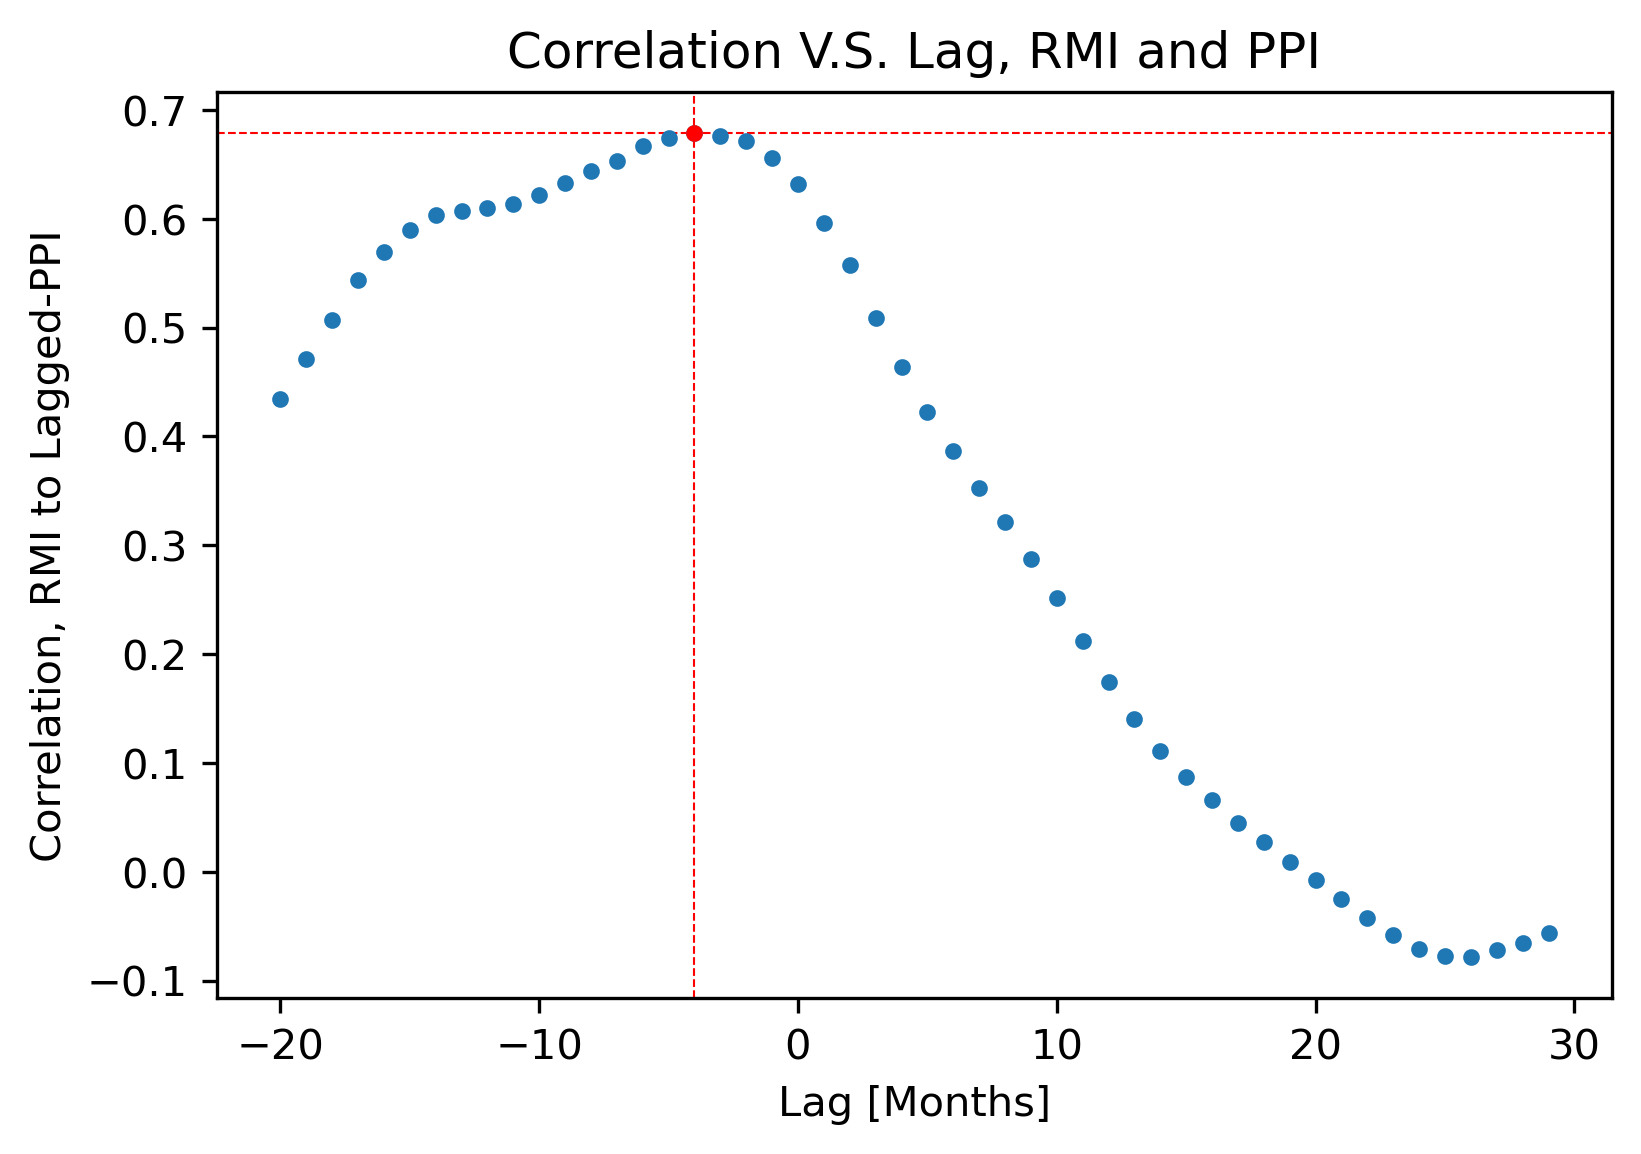

Best correlation is for a lag of -4


In [6]:
# plot correlation vs monthly lag
plt.figure(dpi=300)
plt.axvline(max_lag , linestyle="--", linewidth=0.5, color="red")
plt.axhline(max_corr, linestyle="--", linewidth=0.5, color="red")
plt.plot(lags, correlations, ".")
plt.plot([max_lag], [max_corr], ".r")
plt.title("Correlation V.S. Lag, RMI and PPI")
plt.xlabel("Lag [Months]")
plt.ylabel("Correlation, RMI to Lagged-PPI")
plt.show()

print("Best correlation is for a lag of", max_lag)

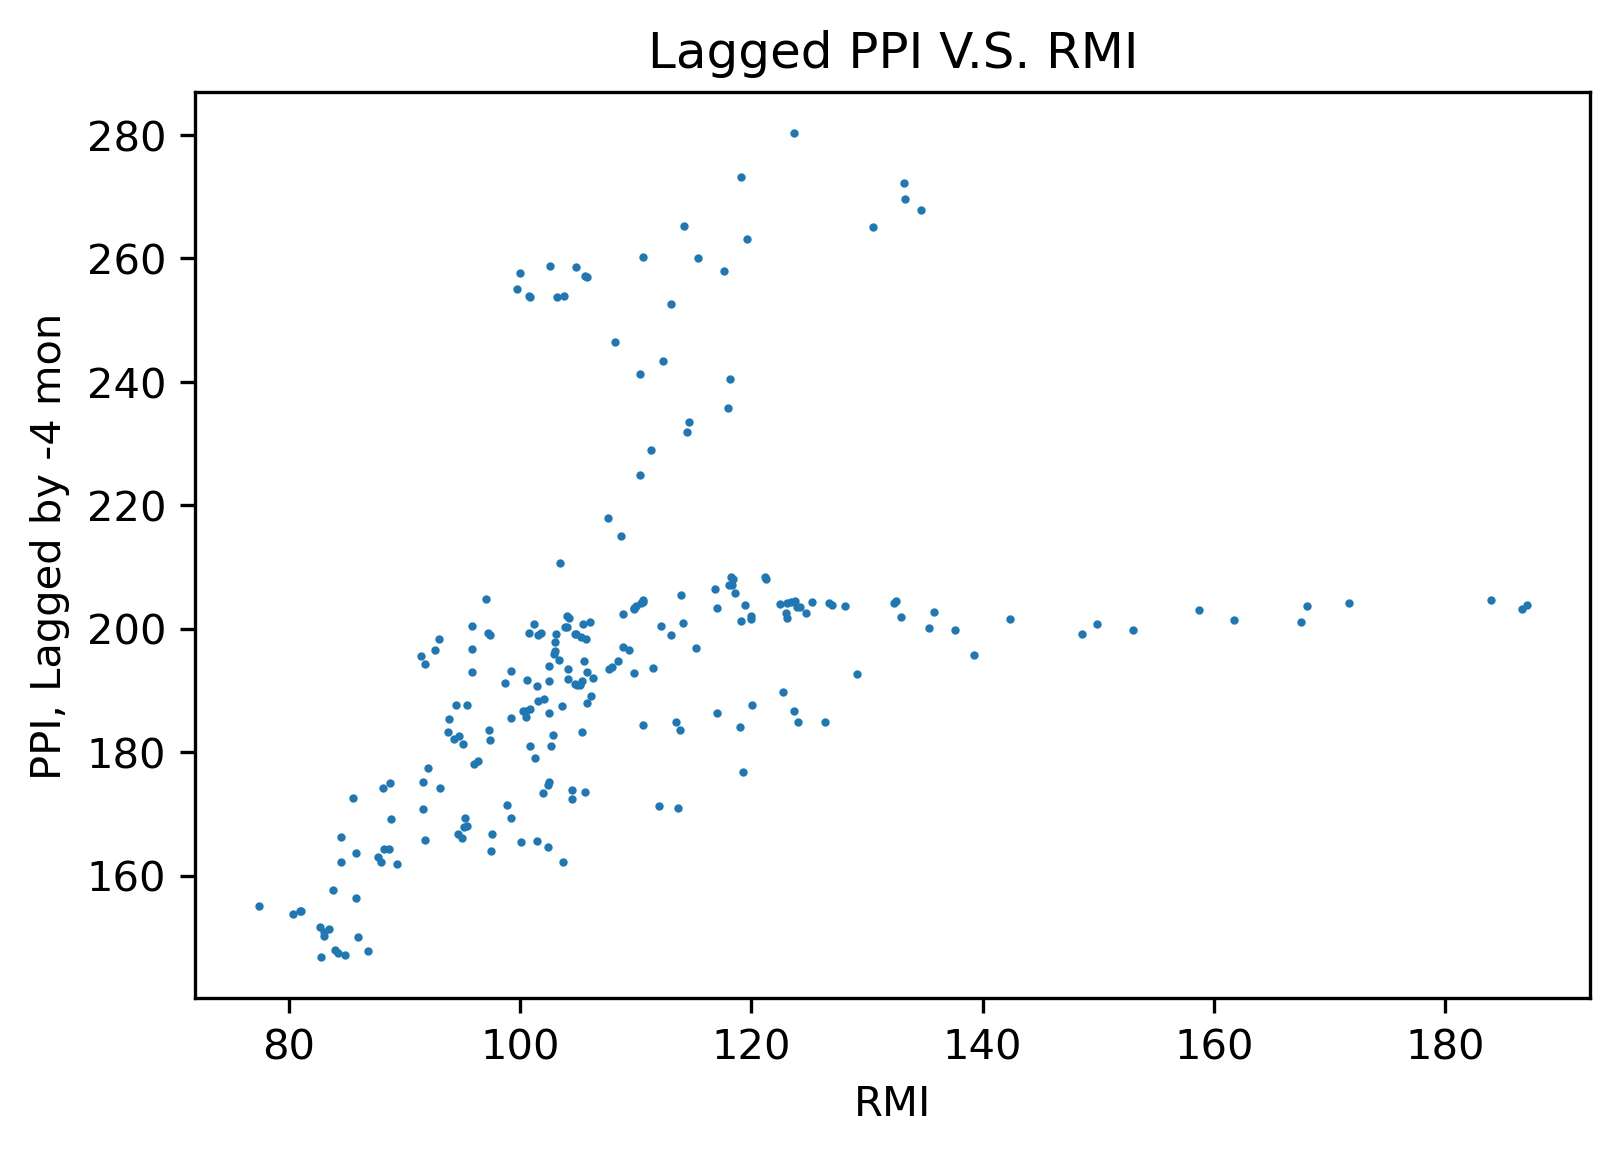

In [7]:
data_lags = pd.DataFrame(data_merged)

# shift ppi data by max_lag, dropping the NA values this creates
data_lags["ppi-lag-"+str(max_lag)] = data_merged["ppi"].shift(max_lag)
data_lags = data_lags.dropna()

plt.figure(dpi=300)
plt.scatter(data_lags["rmi"], data_lags["ppi-lag-"+str(max_lag)], s=1)
plt.title("Lagged PPI V.S. RMI")
plt.xlabel("RMI")
plt.ylabel("PPI, Lagged by "+str(max_lag)+" mon")
plt.show()

# note: data doens't seem too monotonic...

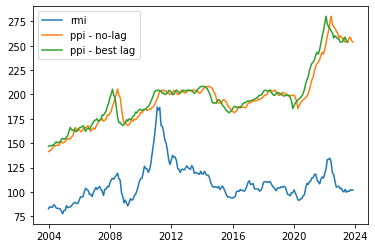

In [8]:
plt.plot(data_merged["rmi"], label="rmi")
plt.plot(data_merged["ppi"], label="ppi - no-lag")
plt.plot(data_lags["ppi-lag--4"], label="ppi - best lag")
plt.legend()

plt.show()

In [9]:
for index_name in ["moi", "rmi", "ppi"]:
    # initial value
    first_entry = data_merged[index_name].iloc[0]
    
    # add a new column with the % change since the initial value
    data_merged[index_name+"_delta%"] = (data_merged[index_name] / first_entry - 1) * 100

data_merged.head()

,rmi,ppi,moi,moi_delta%,rmi_delta%,ppi_delta%
2004-01-01,82.776881,141.4,164926.0,0.000000,0.000000,0.000000
2004-02-01,84.886602,142.1,180111.0,9.207160,2.548684,0.495050
2004-03-01,84.249977,143.1,214611.0,30.125632,1.779598,1.202263
2004-04-01,84.057943,144.8,183752.0,11.414816,1.547609,2.404526
2004-05-01,86.870517,146.8,181865.0,10.270667,4.945386,3.818953


In [10]:
# find correlations between MOI and RMI on % data
correlations_percent_data, lags, data_lags = calc_lagged_cor(data_merged, "rmi_delta%", "moi_delta%")
# find maximum correlation
max_corr = np.max(correlations_percent_data)
max_lag = lags[np.where(correlations_percent_data == max_corr)][0]

In [11]:
np.array(correlations) - np.array(correlations_percent_data)

array([0.36246616, 0.37240635, 0.38193683, 0.40669548, 0.40316238,
       0.41211559, 0.42578081, 0.42614812, 0.4256854 , 0.42284652,
       0.41168487, 0.41273851, 0.42373896, 0.42001207, 0.42173312,
       0.41980487, 0.40321984, 0.39128908, 0.4026452 , 0.38257424,
       0.37702922, 0.35923495, 0.33604748, 0.31332914, 0.30906706,
       0.30376124, 0.3067149 , 0.30328025, 0.30633369, 0.31108409,
       0.32899474, 0.33807496, 0.35352049, 0.35520008, 0.35579646,
       0.36238007, 0.38848255, 0.38672193, 0.38639795, 0.38929256,
       0.37311332, 0.36145511, 0.37184963, 0.35702522, 0.34448676,
       0.34026645, 0.30686014, 0.28593769, 0.2847161 , 0.24817828])

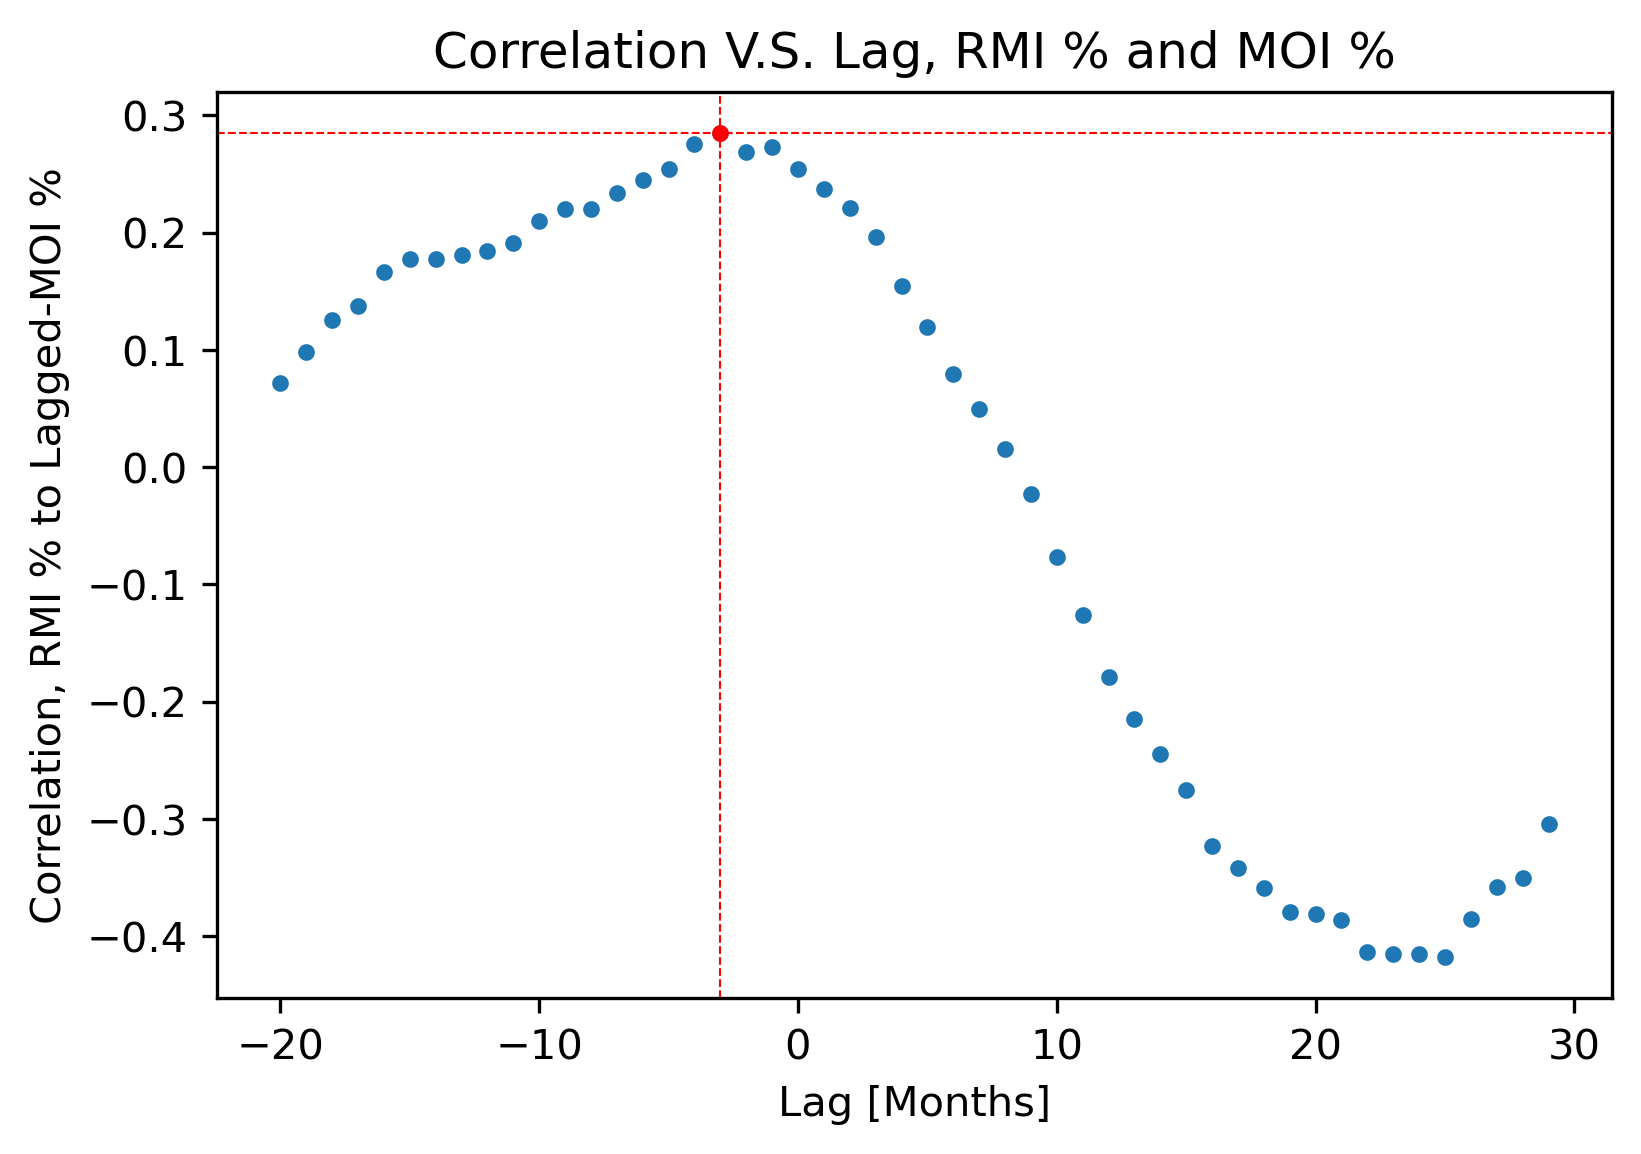

Best correlation is for a lag of -3


In [14]:
# plot correlation vs monthly lag
plt.figure(dpi=300)
plt.axvline(max_lag , linestyle="--", linewidth=0.5, color="red")
plt.axhline(max_corr, linestyle="--", linewidth=0.5, color="red")
plt.plot(lags, correlations_percent_data, ".")
plt.plot([max_lag], [max_corr], ".r")
plt.title("Correlation V.S. Lag, RMI % and MOI %")
plt.xlabel("Lag [Months]")
plt.ylabel("Correlation, RMI % to Lagged-MOI %")
plt.show()

print("Best correlation is for a lag of", max_lag)

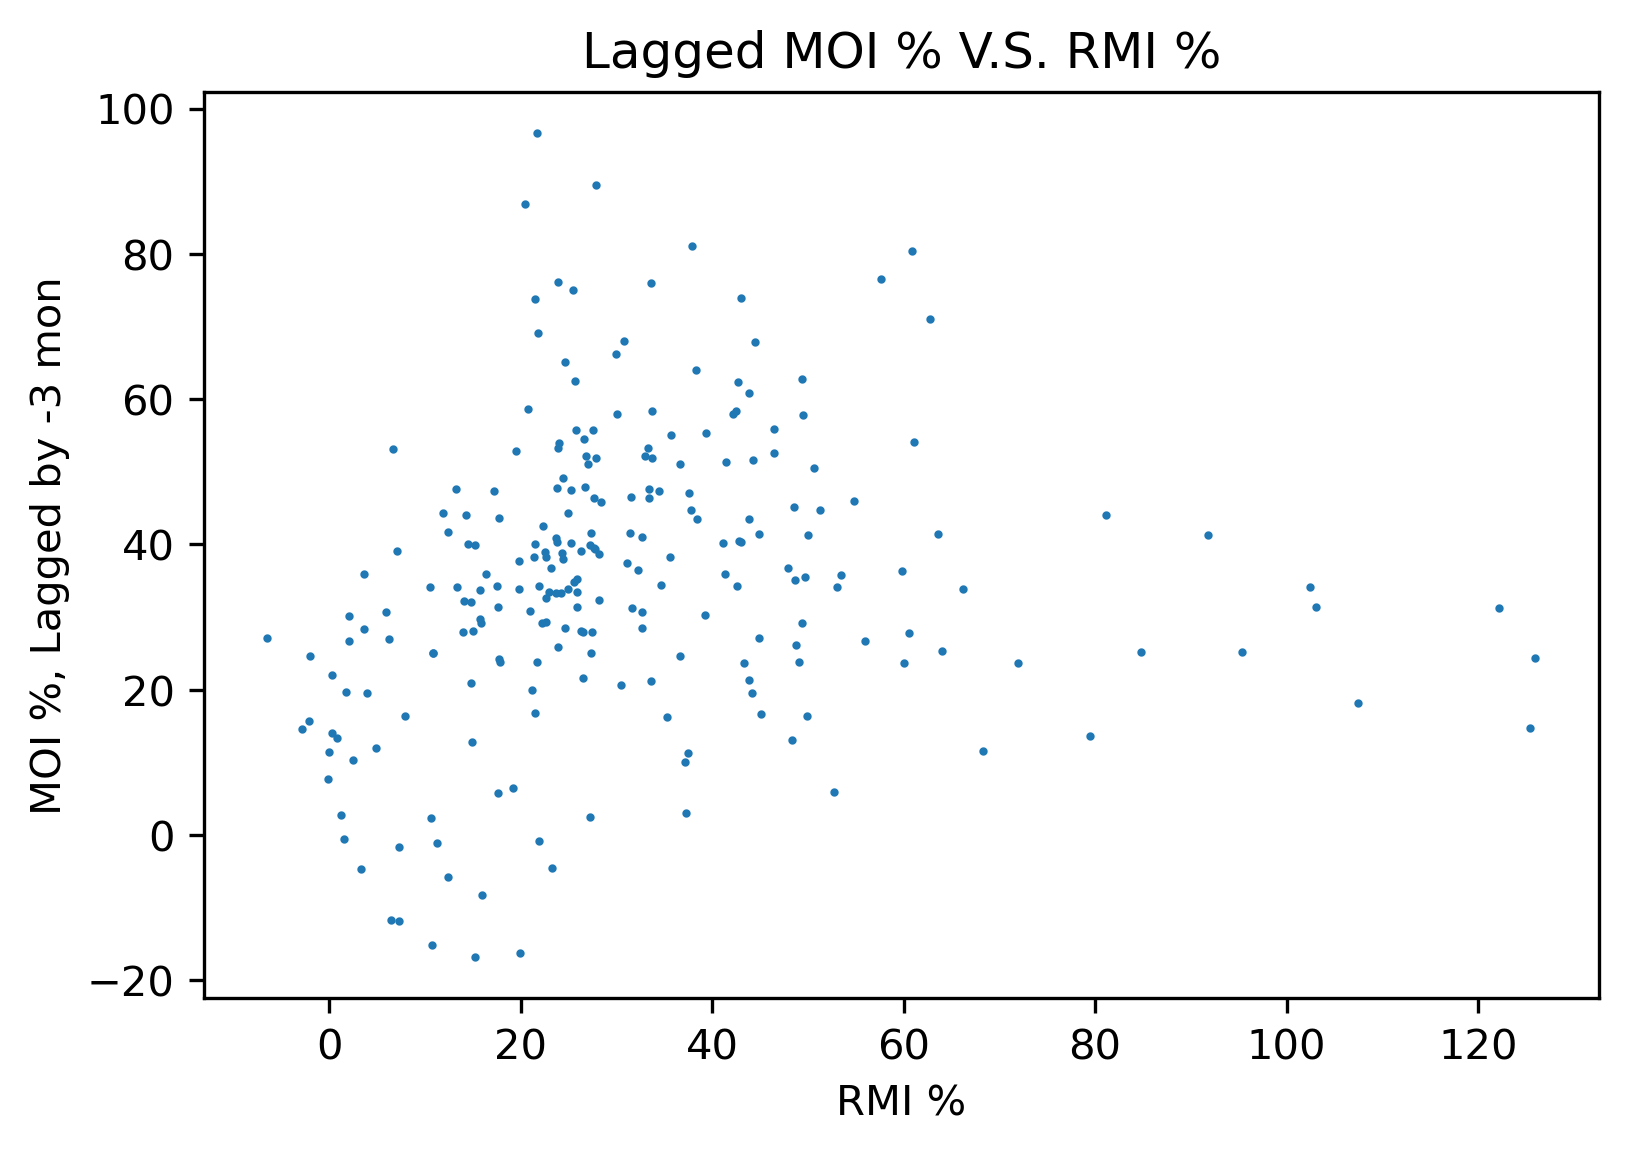

In [15]:
data_lags = pd.DataFrame(data_merged)

# shift ppi data by max_lag, dropping the NA values this creates
data_lags["moi_delta%-lag-"+str(max_lag)] = data_merged["moi_delta%"].shift(max_lag)
data_lags = data_lags.dropna()

plt.figure(dpi=300)
plt.scatter(data_lags["rmi_delta%"], data_lags["moi_delta%-lag-"+str(max_lag)], s=1)
plt.title("Lagged MOI % V.S. RMI %")
plt.xlabel("RMI %")
plt.ylabel("MOI %, Lagged by "+str(max_lag)+" mon")
plt.show()

# note: has not changed at all from previous result.

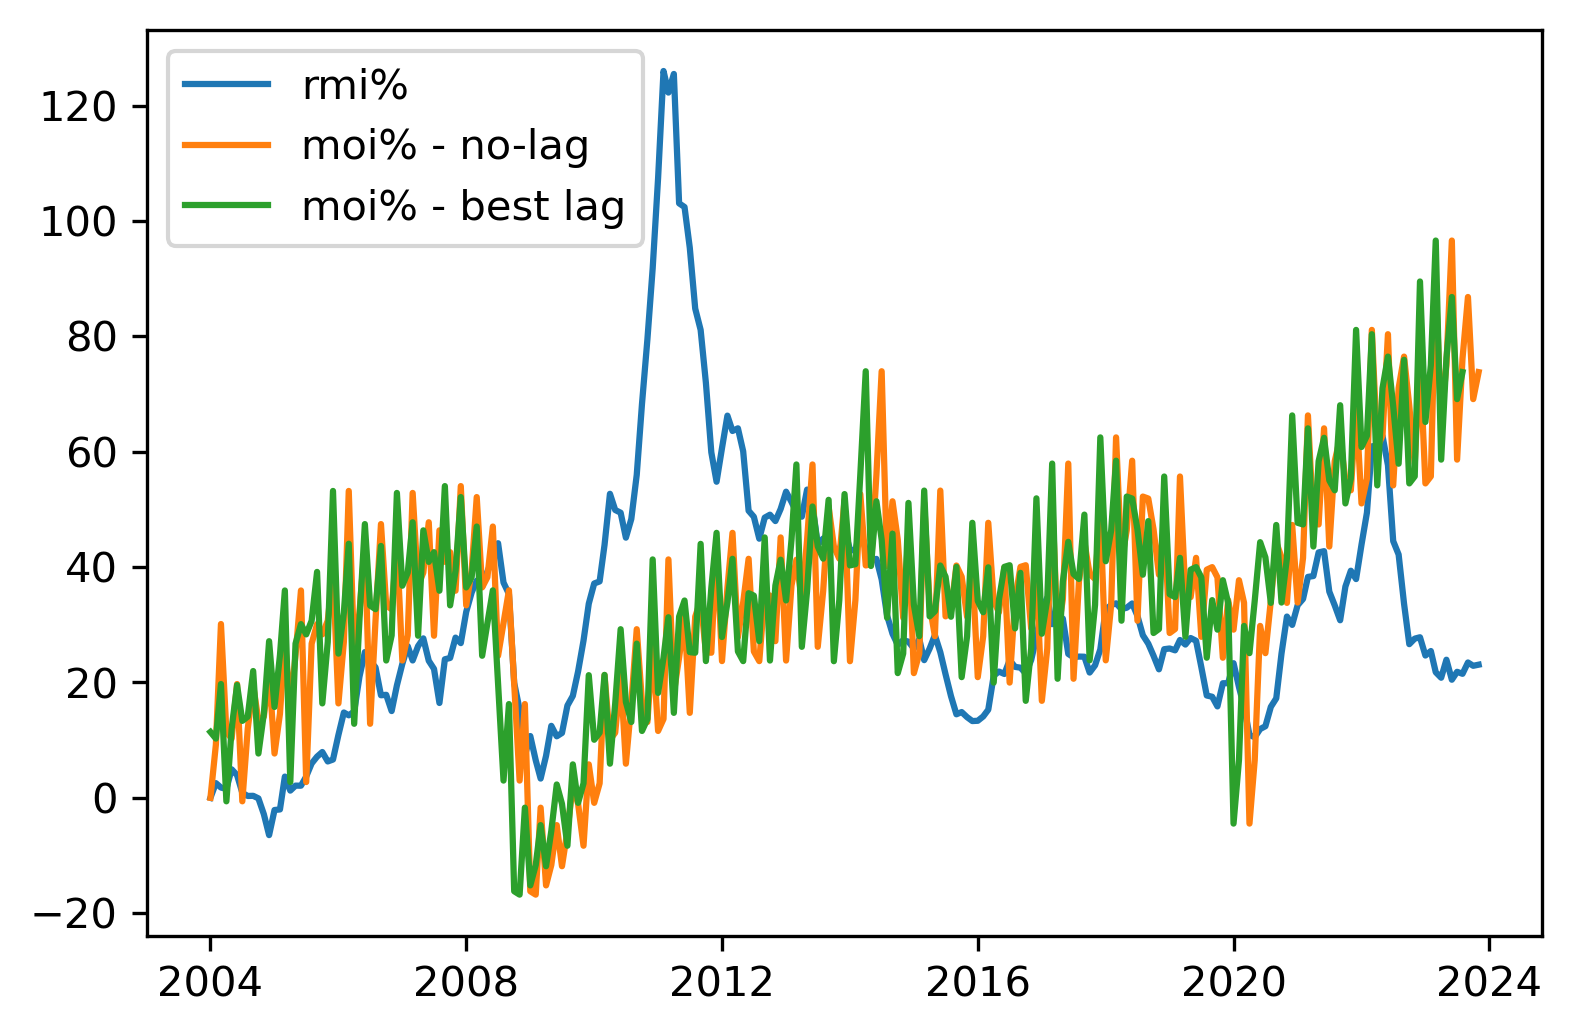

In [16]:
plt.figure(dpi=300)
plt.plot(data_merged["rmi_delta%"], label="rmi%")
plt.plot(data_merged["moi_delta%"], label="moi% - no-lag")
plt.plot(data_lags["moi_delta%-lag--3"], label="moi% - best lag")
plt.legend()

plt.show()

### 3 -- Feature transformations

In [18]:
from statsmodels.tsa.stattools import adfuller

# perform the Augmented Dickey Fuller test
# second value is p-value, null hypothesis being non-stationarity
adfuller(data_ppi['value'])

(-1.324139572591459,
 0.6180573545381273,
 2,
 236,
 {'1%': -3.4583663275730476,
  '5%': -2.8738660999177132,
  '10%': -2.5733390785693766},
 1009.6360910702927)

In [119]:
adfuller(data_rmi['value'])

(-3.125558108244732,
 0.024718686912832837,
 2,
 236,
 {'1%': -3.4583663275730476,
  '5%': -2.8738660999177132,
  '10%': -2.5733390785693766},
 1191.989624930655)

In [128]:
# note: ppi data has a very high p-value, so null hypothesis is likely true
print("PPI has p-value of ", round(adfuller(data_ppi['value'])[1],3), "so the series is non-stationary.")
print("RMI has p-value of ", round(adfuller(data_rmi['value'])[1],3), "so the series is     stationary.")

PPI has p-value of  0.618 so the series is non-stationary.
RMI has p-value of  0.025 so the series is     stationary.


RMI has p-value of  0.385 so the series is now *non-stationary*.


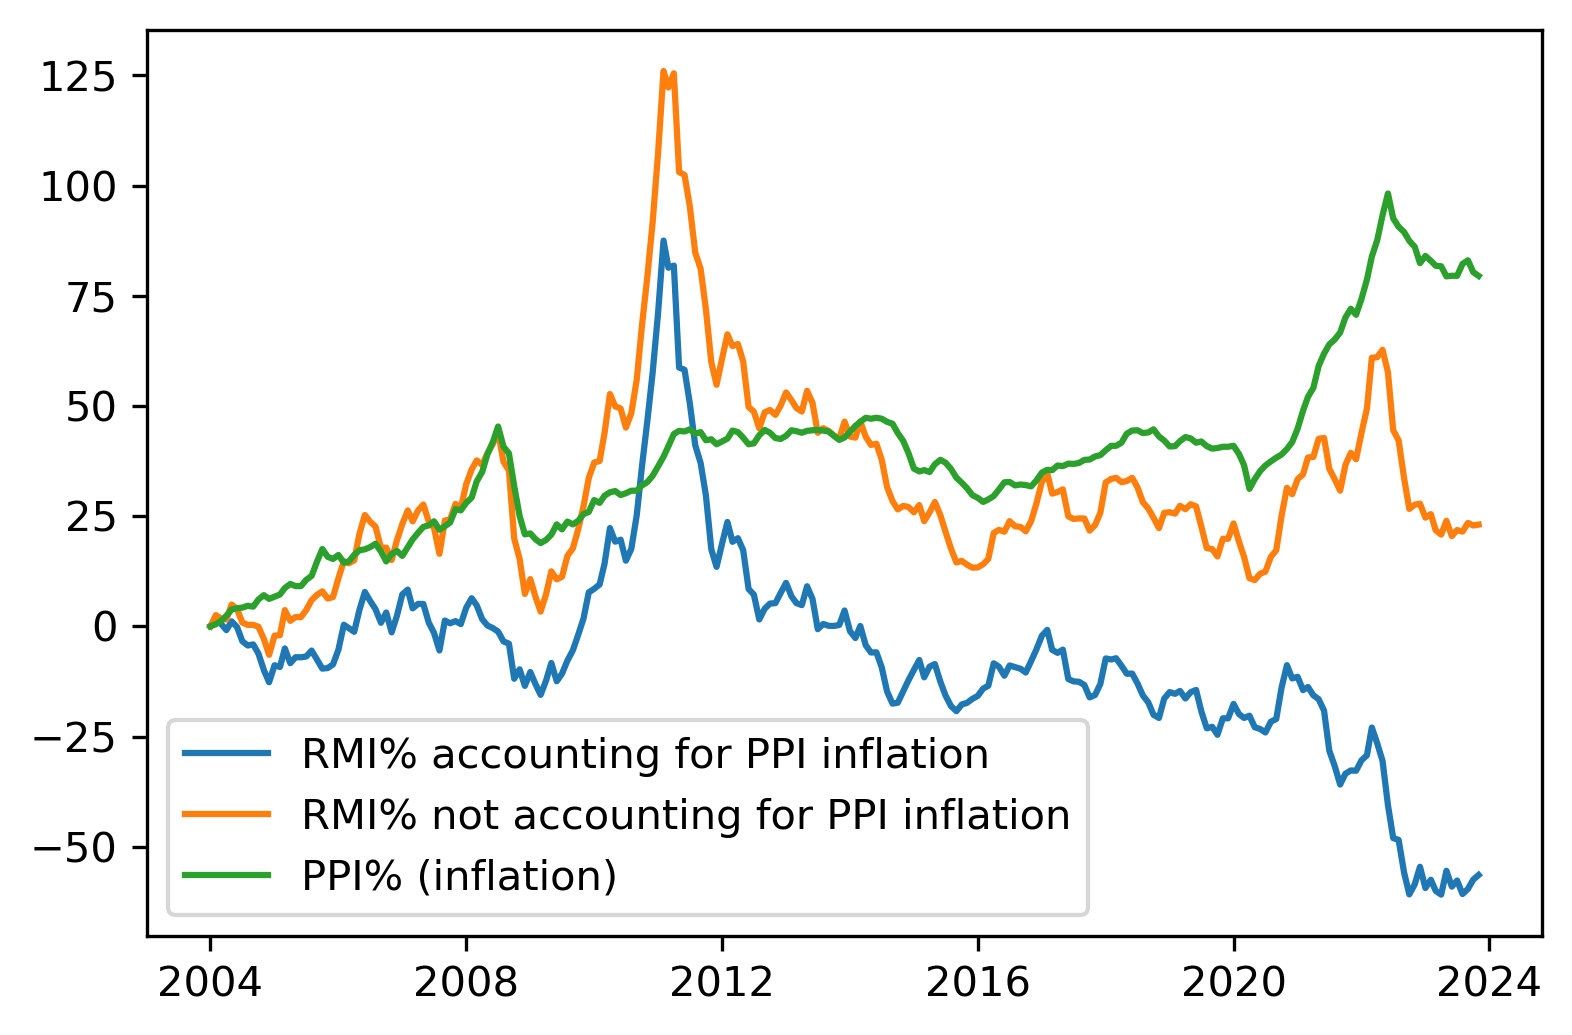

In [20]:
# Now, let's adjust RMI for PPI inflation and try again.
# calculate % changes again
data_rmi["%"] = (data_rmi["value"] / data_rmi["value"].iloc[0] - 1) * 100
data_ppi["%"] = (data_ppi["value"] / data_ppi["value"].iloc[0] - 1) * 100
data_moi["%"] = (data_moi["value"] / data_moi["value"].iloc[0] - 1) * 100

data_rmi["%-with-ppi-inflation"] = data_rmi["%"] - data_ppi["%"]

print("RMI has p-value of ", round(adfuller(data_rmi["%-with-ppi-inflation"])[1],3), "so the series is now *non-stationary*.")

plt.figure(dpi=300)
plt.plot(data_rmi["%-with-ppi-inflation"], label="RMI% accounting for PPI inflation")
plt.plot(data_rmi["%"], label="RMI% not accounting for PPI inflation")
plt.plot(data_ppi["%"], label="PPI% (inflation)")
plt.legend()
plt.show()

# makes more sense now -- inflation went up a LOT since ~2020, but the price of materials actually decreased.

In [73]:
data_moi["%"]

2004-07-01    -0.606939
2004-08-01    11.966579
2004-09-01    19.548767
2004-10-01    13.334465
2004-11-01    14.069947
                ...    
2023-01-01    54.499594
2023-02-01    55.722566
2023-03-01    89.500139
2023-04-01    65.149825
2023-05-01    75.011823
Name: %, Length: 227, dtype: float64

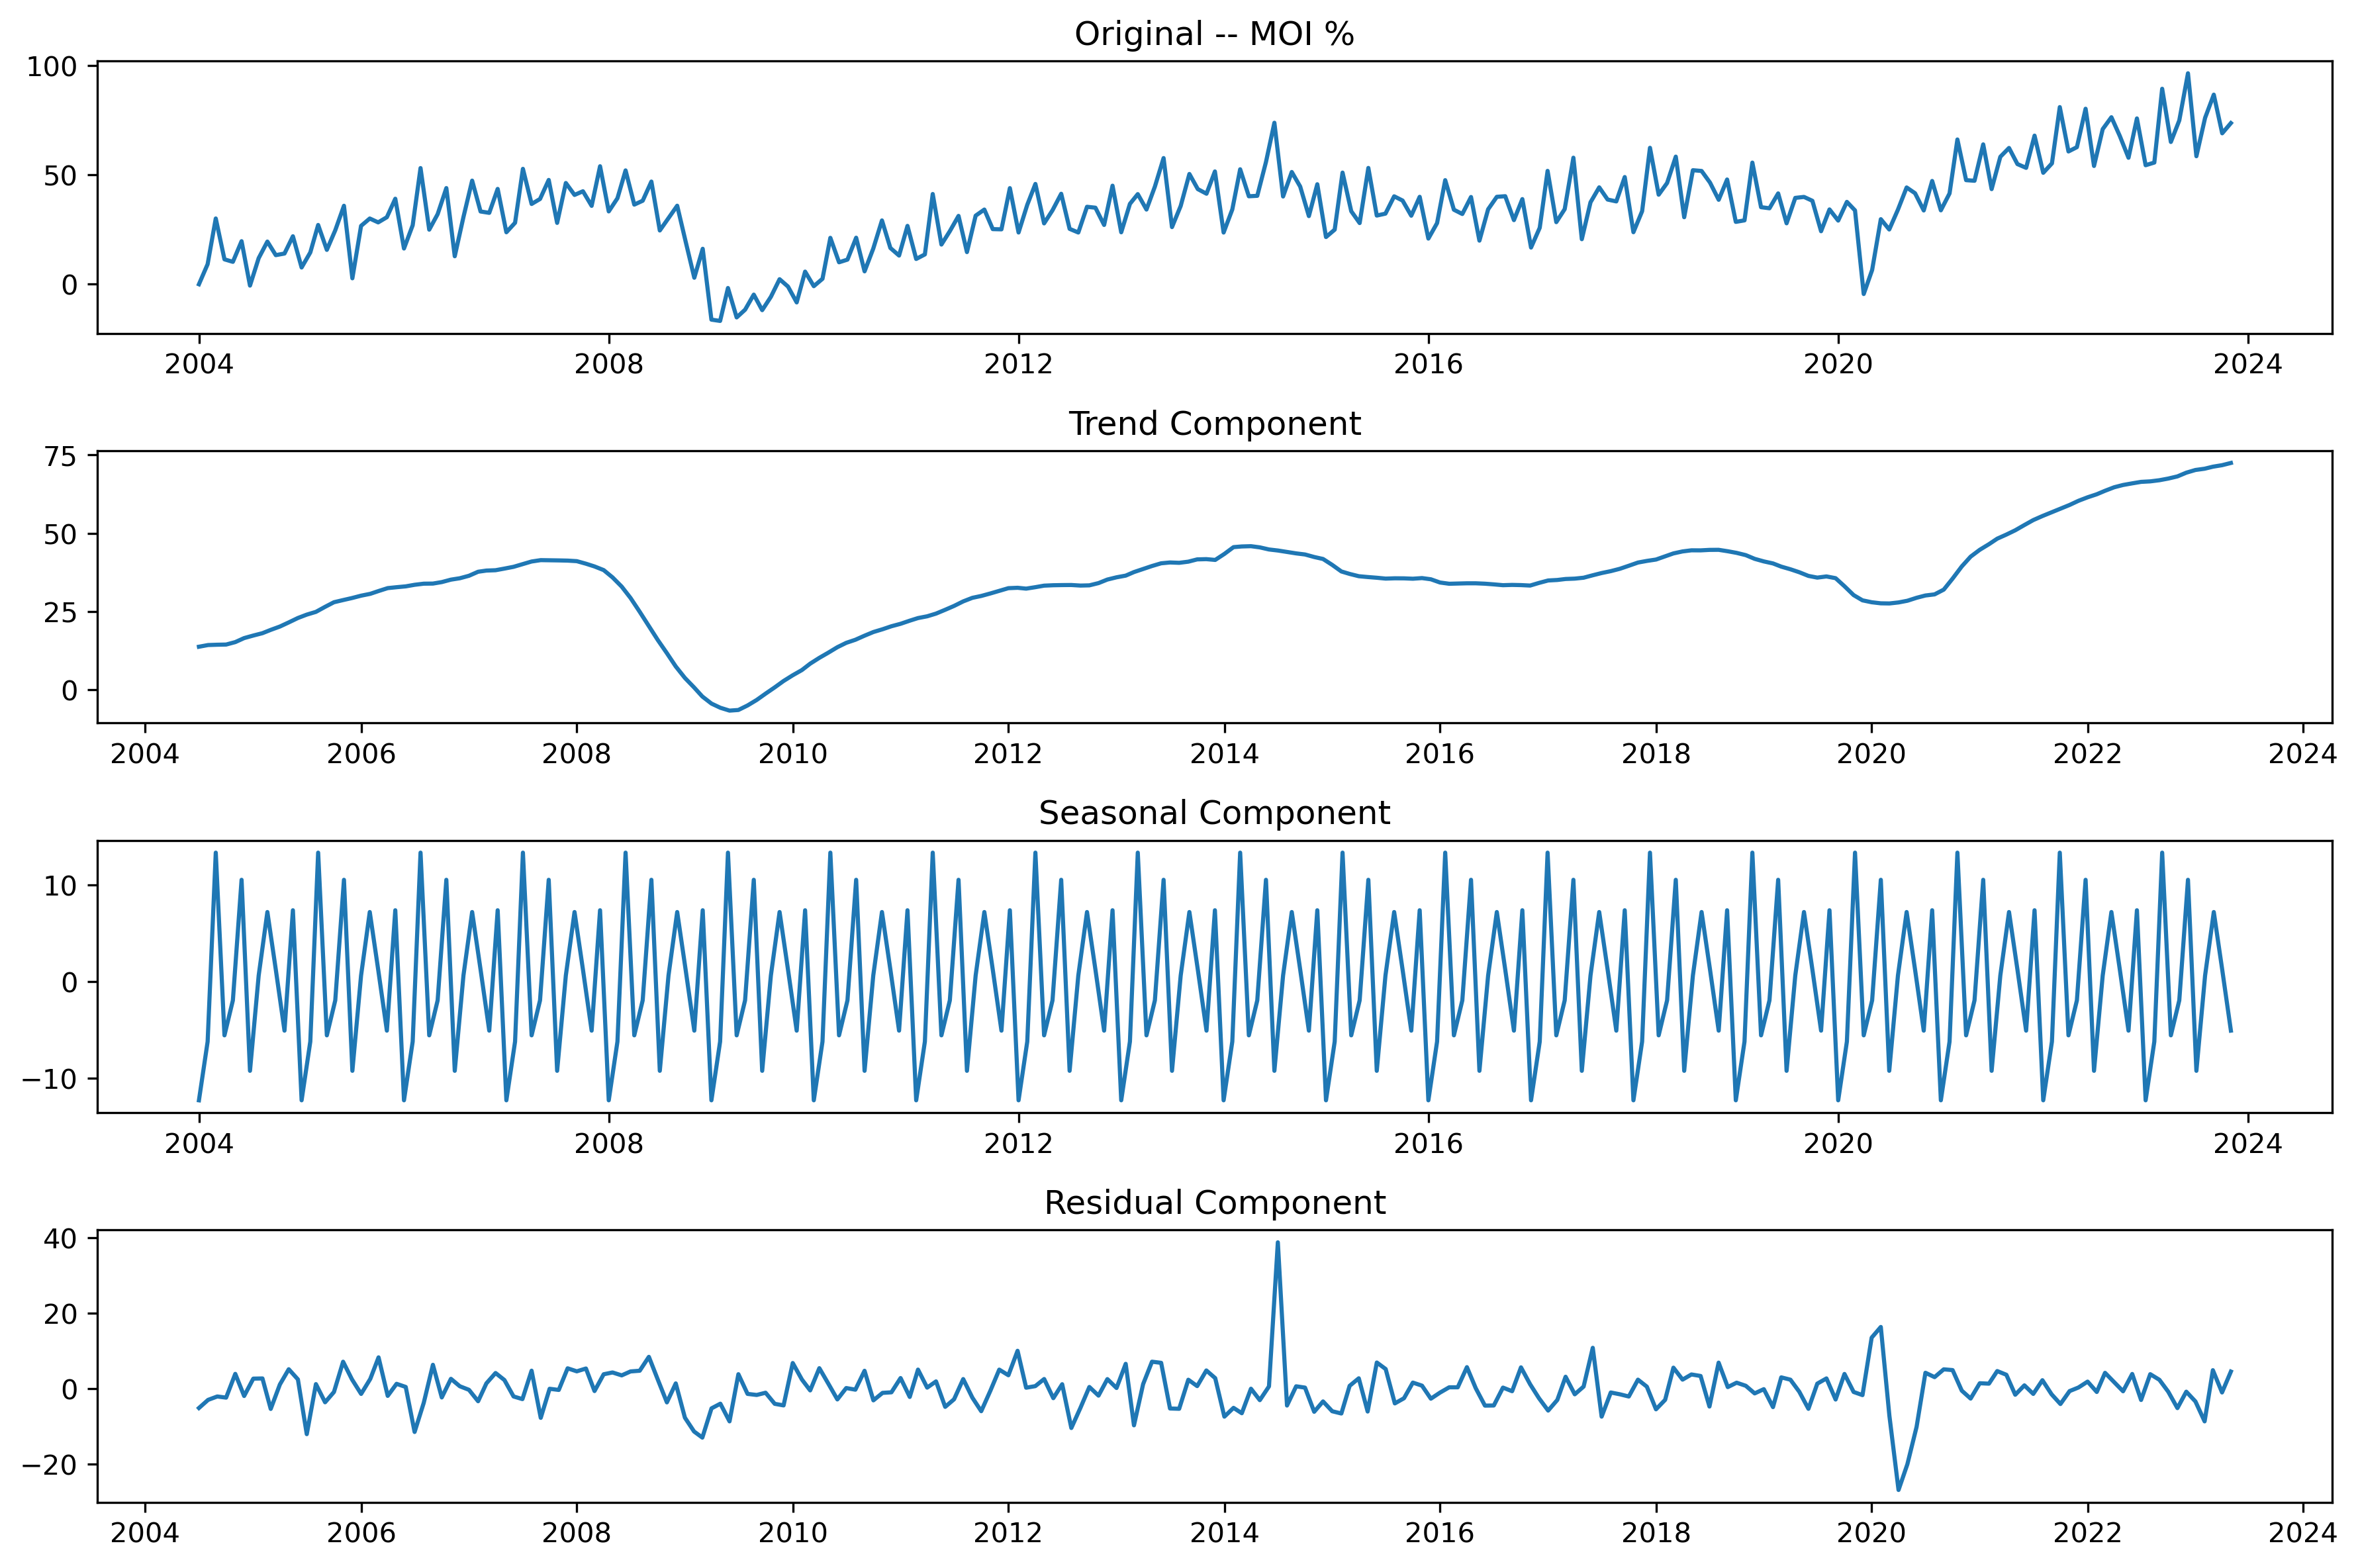

In [38]:
from statsmodels.tsa.seasonal import seasonal_decompose
# decompose the trend and seasonality from the adjusted MOI data
res = seasonal_decompose(data_moi["%"], model='additive', 
                         filt=None, period=None, two_sided=True, extrapolate_trend=0)
# Access the components
trend = res.trend
seasonal = res.seasonal
residual = res.resid

# Plot the original time series, trend, seasonal, and residual components
plt.figure(figsize=(12, 8), dpi=300)

plt.subplot(4, 1, 1)
plt.plot(data_moi['%'])
plt.title('Original -- MOI %')

plt.subplot(4, 1, 2)
plt.plot(trend)
plt.title('Trend Component')

plt.subplot(4, 1, 3)
plt.plot(seasonal)
plt.title('Seasonal Component')

plt.subplot(4, 1, 4)
plt.plot(residual)
plt.title('Residual Component')

plt.tight_layout()
plt.show()

In [58]:
data_merged

,rmi,ppi,moi,moi_delta%,rmi_delta%,ppi_delta%,moi_res
2004-07-01,83.486083,147.400,163925.0,-0.606939,0.856763,4.243281,-5.094917
2004-08-01,83.044010,148.000,184662.0,11.966579,0.322710,4.667610,-2.944367
2004-09-01,83.065261,147.700,197167.0,19.548767,0.348383,4.455446,-2.043744
2004-10-01,82.697579,150.000,186918.0,13.334465,-0.095802,6.082037,-2.347380
2004-11-01,80.426734,151.400,188131.0,14.069947,-2.839134,7.072136,3.935288
...,...,...,...,...,...,...,...
2023-01-01,103.194312,260.227,254810.0,54.499594,24.665620,84.036068,-3.366557
2023-02-01,103.841031,258.669,256827.0,55.722566,25.446900,82.934229,-8.629317
2023-03-01,100.798108,257.062,312535.0,89.500139,21.770845,81.797737,4.911127
2023-04-01,100.005735,256.908,272375.0,65.149825,20.813607,81.688826,-0.980919


In [96]:
# save the residual component from the de-seasonalized data to a new column
data_merged["moi_res%"] = residual
# also add the RMI adjusted for MOI inflation
data_merged["rmi_delta%_with_ppi_inflation"] = data_rmi["%-with-ppi-inflation"]
# de-seasonalizing introduces some NaN values at the starts and ends, remove them
data_merged = data_merged.dropna()

# get ready for regression
independent = data_merged["moi_res%"]
dependent   = data_merged["rmi_delta%_with_ppi_inflation"]

In [97]:
import statsmodels.api as sm

lags = range(1, 31)
R_squared = []

# Iterate over each lag, run the regression, and store R-squared values
for lag in lags:
    # Create lagged variable
    independent_lagged = independent.shift(lag).dropna()
    
    # Select corresponding dependent variable (excluding NaN values introduced by shifting)
    dependent_subset = dependent[lag:].dropna()
    
    # Perform linear regression
    X       = sm.add_constant(independent_lagged)
    model   = sm.OLS(dependent_subset, X)
    results = model.fit()
    
    # Store R-squared value
    R_squared.append(results.rsquared)

    
max_R_squared = np.max(R_squared)
max_lag = lags[np.where(R_squared == max_R_squared)[0][0]]

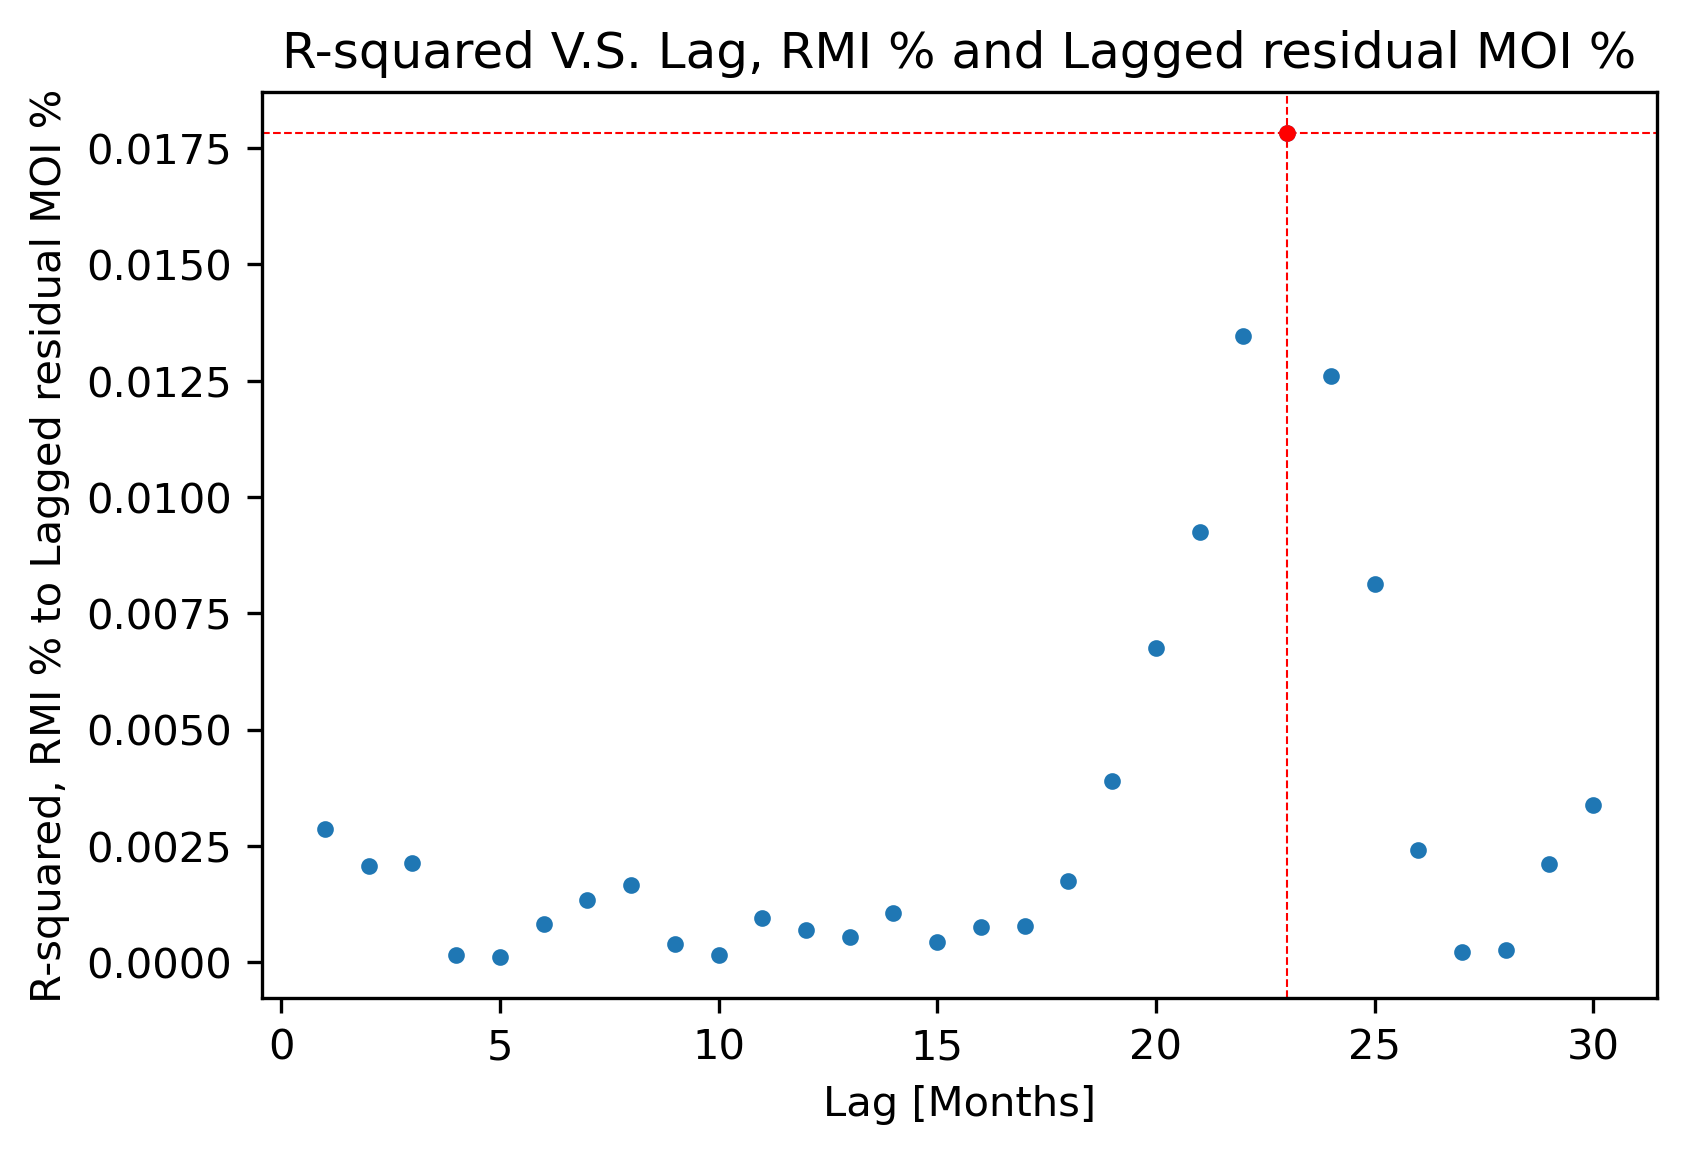

Max R-squared is for a lag of 23


In [98]:
# plot R-squared values vs monthly lag
plt.figure(dpi=300)
plt.axvline(max_lag , linestyle="--", linewidth=0.5, color="red")
plt.axhline(max_R_squared, linestyle="--", linewidth=0.5, color="red")
plt.plot(lags, R_squared, ".")
plt.plot([max_lag], [max_R_squared], ".r")
plt.title("R-squared V.S. Lag, RMI % and Lagged residual MOI %")
plt.xlabel("Lag [Months]")
plt.ylabel("R-squared, RMI % to Lagged residual MOI %")
plt.show()



print("Max R-squared is for a lag of", max_lag)

In [99]:
data_merged

,rmi,ppi,moi,moi_delta%,rmi_delta%,ppi_delta%,moi_res,rmi_delta%_with_ppi_inflation,moi_res%
2004-07-01,83.486083,147.400,163925.0,-0.606939,0.856763,4.243281,-5.094917,-3.386518,-5.094917
2004-08-01,83.044010,148.000,184662.0,11.966579,0.322710,4.667610,-2.944367,-4.344900,-2.944367
2004-09-01,83.065261,147.700,197167.0,19.548767,0.348383,4.455446,-2.043744,-4.107063,-2.043744
2004-10-01,82.697579,150.000,186918.0,13.334465,-0.095802,6.082037,-2.347380,-6.177839,-2.347380
2004-11-01,80.426734,151.400,188131.0,14.069947,-2.839134,7.072136,3.935288,-9.911270,3.935288
...,...,...,...,...,...,...,...,...,...
2023-01-01,103.194312,260.227,254810.0,54.499594,24.665620,84.036068,-3.366557,-59.370448,-3.366557
2023-02-01,103.841031,258.669,256827.0,55.722566,25.446900,82.934229,-8.629317,-57.487329,-8.629317
2023-03-01,100.798108,257.062,312535.0,89.500139,21.770845,81.797737,4.911127,-60.026892,4.911127
2023-04-01,100.005735,256.908,272375.0,65.149825,20.813607,81.688826,-0.980919,-60.875220,-0.980919


In [100]:
# now, run multiple regression using the PPI% change and MOI residual% change as X values,
# and the raw RMI% change as Y

# Select independent variables (X) and dependent variable (Y)
X = data_merged[['ppi_delta%', 'moi_res%']]
Y = data_merged['rmi_delta%']

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Perform multiple regression
model = sm.OLS(Y, X)
results = model.fit()



In [108]:
# how much variance does adding the inflation adjustment actually explain?

# Perform simple regression with only MOI residual percent change
X_simple = sm.add_constant(data_merged['moi_res%'])
model_simple = sm.OLS(Y, X_simple)
results_simple = model_simple.fit()

# Calculate additional variation explained
additional_variation = results.rsquared - results_simple.rsquared

print(f"R-squared (Multiple Regression):              {results.rsquared}")
print(f"R-squared (Simple Regression):                {results_simple.rsquared}")
print(f"Additional Variation Explained by Adding PPI: {additional_variation}")

R-squared (Multiple Regression):              0.17192519861076627
R-squared (Simple Regression):                0.012550303246371297
Additional Variation Explained by Adding PPI: 0.15937489536439498
